# 82 Octet Binary Dataset

In [370]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [371]:
octet = pd.read_csv('octet.csv')
octet_selected = octet[['rp(A)', 'rp(B)', 'rs(A)']]
# octet_selected['sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']
octet_sel = pd.DataFrame()
octet_sel.loc[:, 'sigma'] = octet_selected['rp(A)']-octet_selected['rp(B)']
octet_selected = pd.concat([octet_sel, octet_selected], axis=1)
# octet_selected = octet_selected.to_numpy()

In [372]:

octet_selected.loc[(octet_selected['sigma']>=0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=-0.91) & (octet_selected['rs(A)'] >=1.22), 'RS_ZB'] = 1 
octet_selected.loc[(octet_selected['sigma']<=1.16) & (octet_selected['sigma']>=-1.16) & (octet_selected['rs(A)'] <=1.27), 'RS_ZB'] = -1 
octet_selected.loc[octet_selected['RS_ZB'].isnull(), 'RS_ZB'] = 0

octet_selected.loc[(octet_selected['sigma']>=0.91), 'sigma>0.91'] = 1
octet_selected.loc[octet_selected['sigma>0.91'].isnull(), 'sigma>0.91'] = 0

octet_selected.loc[(octet_selected['sigma']<=-0.91), 'sigma<-0.91'] = 1 
octet_selected.loc[octet_selected['sigma<-0.91'].isnull(), 'sigma<-0.91'] = 0

octet_selected.loc[(octet_selected['rs(A)']>=1.22), 'rs>1.22'] = 1 
octet_selected.loc[octet_selected['rs>1.22'].isnull(), 'rs>1.22'] = 0

octet_selected.loc[(octet_selected['sigma']<=1.16), 'sigma<1.16'] = 1 
octet_selected.loc[octet_selected['sigma<1.16'].isnull(), 'sigma<1.16'] = 0

octet_selected.loc[(octet_selected['sigma']>=-1.16), 'sigma>-1.16'] = 1 
octet_selected.loc[octet_selected['sigma>-1.16'].isnull(), 'sigma>-1.16'] = 0

octet_selected.loc[(octet_selected['rs(A)']<=1.27), 'rs<1.27'] = 1 
octet_selected.loc[octet_selected['rs<1.27'].isnull(), 'rs<1.27'] = 0

In [373]:
second_layer_data = octet_selected[['sigma>0.91', 'sigma<-0.91', 'rs>1.22',	'sigma<1.16', 'sigma>-1.16', 'rs<1.27', 'RS_ZB']]
X = octet_selected[['sigma>0.91', 'sigma<-0.91', 'rs>1.22',	'sigma<1.16', 'sigma>-1.16', 'rs<1.27']].to_numpy()
y = octet_selected['RS_ZB'].to_numpy()

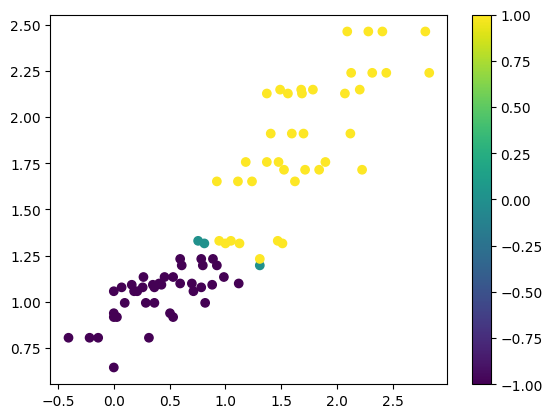

In [374]:
from matplotlib import pyplot as plt
# ax.scatter(octet_selected['sigma'],octet_selected['rs(A)'], octet_selected['RS_ZB'])
plt.scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=octet_selected['RS_ZB'])
plt.colorbar()
plt.show()

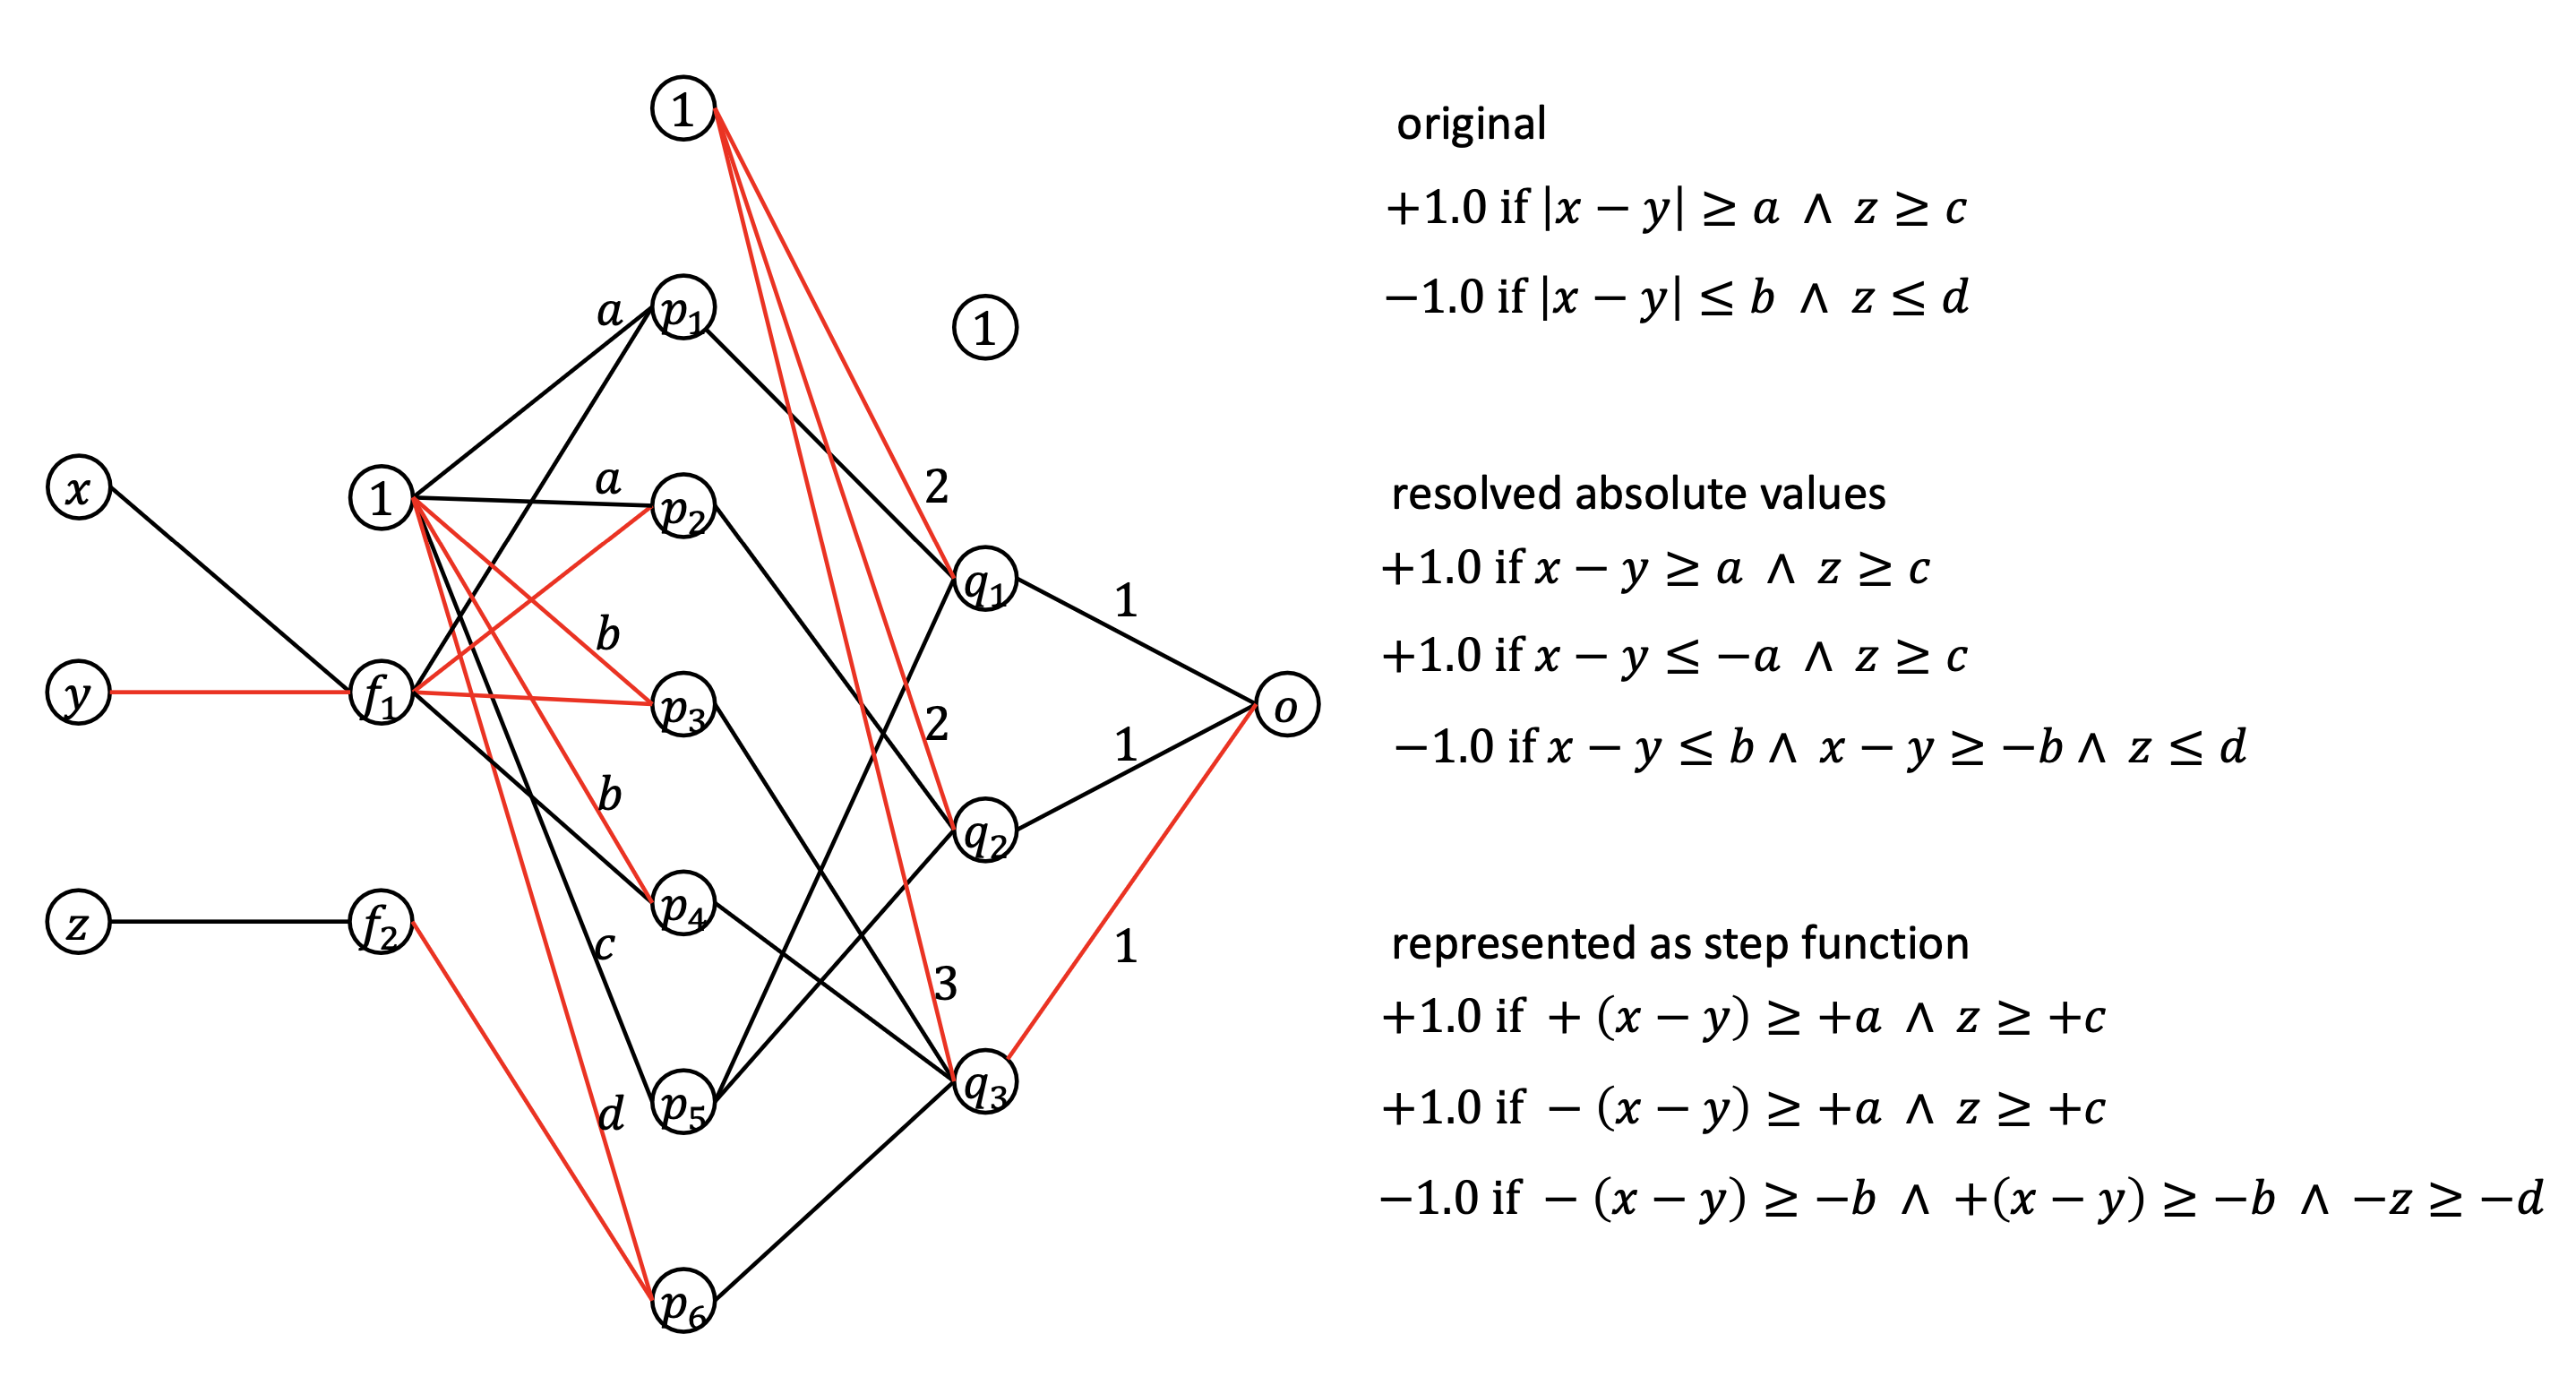

In [375]:
from IPython import display
display.Image("OctetBinary.png")

# Loading Dataset and Transform to Tensor

In [376]:
class OctetBinary(Dataset):
    def __init__(self):
        self.x = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.n_samples = X.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    
dataset = OctetBinary()
dataloader = DataLoader(dataset=dataset, batch_size=82, shuffle=True)

# dataset = TensorDataset(X, y)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Creating the NN Model

In [377]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, alpha):
        super(RegressionModel, self).__init__()
        # Define the hidden layer with sigmoid activation
        self.hidden = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid()
        )
        self.hidden[0].bias.data.fill_(-1.0)
        # Define the output layer with one node (for regression)
        self.output = nn.Linear(hidden_size, 1)
        self.output.bias.data.fill_(-1.0)
        self.alpha = alpha

    def forward(self, x):
        # Forward pass through the network
        x = self.hidden(x)
        x = self.output(x)
        return x
    
    def l1_loss(self):
        l1_loss = 0.0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return self.alpha * l1_loss
    
    

In [378]:
input_size = 6
hidden_size = 3
alpha = 0.001

# Create an instance of the model
model = RegressionModel(input_size, hidden_size, alpha=alpha)

# model before training

for name, param in model.named_parameters():
    print(name, param)

hidden.0.weight Parameter containing:
tensor([[-0.1911,  0.2852,  0.3442,  0.0037,  0.2128, -0.0582],
        [ 0.0373, -0.3887, -0.1297, -0.3732, -0.2242, -0.2729],
        [-0.0681,  0.1460, -0.3569, -0.2356, -0.3076, -0.2025]],
       requires_grad=True)
hidden.0.bias Parameter containing:
tensor([-1., -1., -1.], requires_grad=True)
output.weight Parameter containing:
tensor([[0.3015, 0.0638, 0.1353]], requires_grad=True)
output.bias Parameter containing:
tensor([-1.], requires_grad=True)


# Trainign the Model 

In [379]:
# Define the Mean Squared Error loss function
loss_criterion = nn.MSELoss()
average_epoch_loss_list = []
# Define the optimizer (e.g., Adam)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()  # Zero the gradients
        predictions = model(batch_x)  
        mse_loss = loss_criterion(predictions, batch_y) 
        lasso_loss = model.l1_loss() 
        total_loss = mse_loss  + lasso_loss # Total loss (MSE + if regularization)
        total_loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        epoch_loss += total_loss.item()
    
    # Calculate and print average loss for the epoch
    average_epoch_loss = epoch_loss / len(dataloader)
    average_epoch_loss_list.append(average_epoch_loss)
    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}] Loss: {average_epoch_loss:.4f}')




Epoch [1/100] Loss: 1.7101
Epoch [11/100] Loss: 1.3711
Epoch [21/100] Loss: 1.0976
Epoch [31/100] Loss: 0.9767
Epoch [41/100] Loss: 0.9822
Epoch [51/100] Loss: 0.9765
Epoch [61/100] Loss: 0.9711
Epoch [71/100] Loss: 0.9717
Epoch [81/100] Loss: 0.9707
Epoch [91/100] Loss: 0.9706


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([82])) that is different to the input size (torch.Size([82, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Plots and Results

Text(0, 0.5, '(MSE + Regul.)/batch_size')

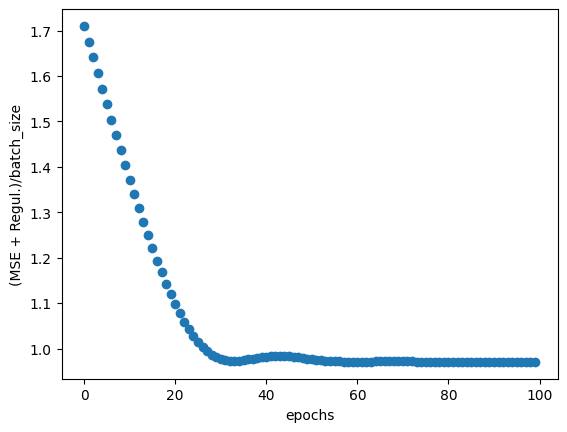

In [380]:
plt.scatter(range(num_epochs), average_epoch_loss_list)
plt.xlabel('epochs')
plt.ylabel('(MSE + Regul.)/batch_size')

In [381]:
weights = []
for name, param in model.named_parameters():
    weights.append(param.detach().numpy())
    print(name, param)

hidden.0.weight Parameter containing:
tensor([[ 6.0086e-02,  1.8215e-05,  5.8948e-01,  3.3018e-01,  5.2451e-01,
          2.8740e-01],
        [ 2.2876e-01,  1.8636e-03,  5.3078e-02,  9.9583e-04,  7.2204e-02,
          7.3088e-02],
        [ 1.2515e-01, -1.8851e-04, -8.6241e-02,  8.2419e-02,  8.5399e-03,
          1.4723e-01]], requires_grad=True)
hidden.0.bias Parameter containing:
tensor([-0.6687, -0.6483, -0.6552], requires_grad=True)
output.weight Parameter containing:
tensor([[0.6047, 0.3606, 0.4403]], requires_grad=True)
output.bias Parameter containing:
tensor([-0.7041], requires_grad=True)


In [382]:
print(f'First Layer Weights (6 to 3): {np.round(weights[0], 3)}')
print(f'First Layer Bias (1 to 3): {np.round(weights[1], 3)}')
print()
print(f'Last Layer Weights (3 to 1): {np.round(weights[2], 3)}')
print(f'Last Layer Bias (3 to 1): {np.round(weights[3], 3)}')

First Layer Weights (6 to 3): [[ 0.06   0.     0.589  0.33   0.525  0.287]
 [ 0.229  0.002  0.053  0.001  0.072  0.073]
 [ 0.125 -0.    -0.086  0.082  0.009  0.147]]
First Layer Bias (1 to 3): [-0.669 -0.648 -0.655]

Last Layer Weights (3 to 1): [[0.605 0.361 0.44 ]]
Last Layer Bias (3 to 1): [-0.704]


In [383]:
def predict(input):
    model.eval()
    input = torch.tensor(input, dtype=torch.float32)

    with torch.no_grad():
        output = model(input)

    model.train()
    
    return output.numpy()

y_pred = predict(X)

print(f'MSE is: {(np.mean((y-y_pred)**2))}')

MSE is: 0.9637083206868171


In [384]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# axs[0].scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=y, cmap='viridis')
# axs[1].scatter(octet_selected['sigma'],octet_selected['rs(A)'], c=y_pred, cmap='viridis')

In [385]:
def binary_round(v):
    v = np.asarray(v)
    bv = []
    for x in v:
        if abs(x) < abs(x-1):
            x = 0
        elif abs(x-1) <= abs(x):
            x = 1
        bv.append(x)
    return bv